In [3]:
from main.utils.analysis import *
from main.utils.data_augmentation import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Using TensorFlow backend.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [4]:
params = {'data_pth':'../../1/mj2非银版/data/modeling_data.csv',
    'date_colName': 'apply_date',
    'y_colName': 'credit_target',
    'org_colName':'org',
    'data_encode':'utf-8',
    'key_colNames' : ['mobile_org', 'apply_date', 'org']}
data = get_dataset(**params)
oot_data = data.copy()
oos_data = data.copy()

原始数据有741764条, 根据['mobile_org', 'apply_date', 'org']去重且只保留标签列[0,1]的数据
去重后数据有741764条
credit_target, org被重命名为new_target, new_org; apply_date被格式化为new_date, new_date_ym两列


In [5]:
class Inference(object):
    '''
        init: data, params
        funcs: 
        
        return model, 
    '''
    def __init__(self, **kwargs):
        self.data = kwargs.get('data')
        self.oot_data = kwargs.get("oot_data")
        self.oos_data = kwargs.get('oos_data')
        self.param = kwargs.get('param')
        self.results = kwargs.get("results")
        self.simpler_results = kwargs.get('simpler_results')
        self.dataset_statis = kwargs.get("dataset_statis")
        self.randn = kwargs.get('randn')
        self.score_name = kwargs.get('score_name')
        self.store_pth = kwargs.get("store_pth")
        self.score_transform_func = kwargs.get("score_transform_func")
        self.model = kwargs.get("model")
        self.feas_gain = None
    
    def inference_split_data(self, data, flag):
        
        # 确定X，判定条件不是object类型且不是Y列
        feas = [v for v in data.columns if data[v].dtype!='O' and v!='new_target']
        
        # tr_orgidx存储训练集各个机构索引，tr_idx存储训练集全部索引, val为验证集同样做法
        tr_orgidx, val_orgidx, tr_idx, val_idx = {}, {}, [], []
        
        if flag==True:
            # 分层抽样
            splitter = StratifiedShuffleSplit(n_splits=1, random_state=self.randn, train_size=0.8)

            for org in data.new_org.unique():
                tmp_data = data[data.new_org==org].copy()
                org_index = tmp_data.index

                # 每个机构下分层抽样, 注意不要使用相对索引否则会造成取值错误, 这里使用了绝对索引
                for idx_tr, idx_val in splitter.split(tmp_data[feas], tmp_data['new_target']):
                    tr_orgidx[org] = list(org_index[idx_tr])
                    val_orgidx[org] = list(org_index[idx_val])
                    val_idx += list(org_index[idx_val])
                    tr_idx += list(org_index[idx_tr])
            
            data_tr, data_val = data.loc[tr_idx, ], data.loc[val_idx, ]
            X_tr, X_val, y_tr, y_val = data_tr[feas], data_val[feas], data_tr['new_target'], data_val['new_target']
            return X_tr, X_val, y_tr, y_val, tr_orgidx, val_orgidx
            
        else:
            for org in data.new_org.unique():
                tmp_data = data[data.new_org==org].copy()
                org_index = tmp_data.index
                tr_orgidx[org] = list(org_index)
                tr_idx += list(org_index)
        
            data_tr = data.loc[tr_idx, ]
            X_tr, y_tr = data_tr[feas], data_tr['new_target']
            return X_tr, None, y_tr, None, tr_orgidx, None
    
    def refit(self):
        
        broadcast_with_tar = self.param.get('broadcast_with_tar')
        balanced_badrate = self.param.get("balanced_badrate")
        feas = [v for v in self.data.columns if self.data[v].dtype!='O' and v!='new_target']
        callbacks, val_set = [], None
        
        X_tr, X_val, y_tr, y_val, tr_orgidx, val_orgidx = self.inference_split_data(self.data, False)
        w_tr = re_weight_by_org(y_tr, tr_orgidx, 0.5, broadcast_with_tar, balanced_badrate)
        train_set = lgb.Dataset(X_tr, label=y_tr, weight=w_tr)
        
        if 'stopping_rounds' in self.param.keys():
            self.param.update({'num_iterations': 300})
            callbacks.append(lgb.early_stopping(stopping_rounds=self.param.get('stopping_rounds')))
            
            # 更新训练集与其权重，添加验证集，早停判断标准和训练时一致为auc(不加权计算)
            X_tr, X_val, y_tr, y_val, tr_orgidx, val_orgidx = self.inference_split_data(self.data, True)
            w_tr = re_weight_by_org(y_tr, tr_orgidx, 0.5, broadcast_with_tar, balanced_badrate)
            
            train_set = lgb.Dataset(X_tr, label=y_tr, weight=w_tr)
            val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)
        
        self.model = lgb.train(
                          self.param,
                          verbose_eval=0, 
                          train_set = train_set, 
                          valid_sets = val_set,
                          callbacks = callbacks
                         )
        ## 保存模型
        joblib.dump(self.model, self.store_pth+self.score_name+'.pkl')
        
        return
    
    def fixedbins_results(self, data):
        
        tmp = data[[self.score_name, 'new_target']].copy()
        
        combiner = toad.transform.Combiner()
        combiner.fit(tmp, y=tmp['new_target'], method='quantile', n_bins=10)
        bin_edges = combiner.export().get(self.score_name)
        min_edge = np.min(tmp[self.score_name])
        max_edge = np.max(tmp[self.score_name])
        
        def _bin_to_interval(bin_label, bin_edges):
            if pd.isna(bin_label):
                return 'NaN'
            bin_label = int(bin_label)
            if bin_label == 0:
                return f"[{min_edge}, {bin_edges[0]})"
            elif bin_label == len(bin_edges):
                return f"[{bin_edges[-1]}, {max_edge}]"
            else:
                return f"[{bin_edges[bin_label-1]}, {bin_edges[bin_label]})"

        tmp['bin_'] = combiner.transform(tmp[[self.score_name]])[[self.score_name]]
        tmp['bin'] = tmp['bin_'].apply(lambda x: _bin_to_interval(x, bin_edges))
        tmp['bin'] = tmp['bin'].astype(str)
        
        res = tmp.groupby(['bin']).apply(
            lambda x: pd.Series({
                '变量名': self.score_name,
                '分箱': x['bin'].iloc[0],
                '命中率': round(len(x)*1.0 / tmp.shape[0], 4),
                '坏样率': round(np.mean(x['new_target']), 4),
                '分箱正样本数': x['new_target'].sum(),
                '分箱负样本数': len(x) - x['new_target'].sum(),
                '分箱ks': round(toad.metrics.KS(x[self.score_name], x['new_target']), 4),
                 ## 默认使用等频5分箱计算每个x的iv值
                '分箱iv': calculate_iv(x[[self.score_name]], x['new_target'], 'quantile', 5)[0],
                '分箱lift': round(x['new_target'].mean() / tmp['new_target'].mean(), 2),
                '召回率': round(sum(x['new_target']) * 1.0 / sum(tmp['new_target']) ,4),
                '特异度': round((len(x)-sum(x['new_target'])) * 1.0 / (tmp.shape[0] - sum(tmp['new_target'])), 4)
            })
        )
        
        res = pd.DataFrame(res).reset_index(drop=True).sort_values(by=['分箱'])
        
        res['分箱iv'].replace({np.inf: 0}, inplace=True)
        res['总IV'] = sum(res['分箱iv'])
        res['累计正样本数'], res['累计负样本数'] =  res['分箱正样本数'].cumsum(), res['分箱负样本数'].cumsum()
        res['累计样本数'] = res['累计正样本数'] + res['累计负样本数']
        res['累积命中率'] = res['命中率'].cumsum()
        res['累积提升度'] = round((res['累计正样本数']/res['累计样本数'])*1.0/tmp['new_target'].mean(), 4)
        res['累积召回率'] = round(res['累计正样本数']*1.0/tmp['new_target'].sum(), 4)
        res['累积特异度'] = round(res['累计负样本数']*1.0/(tmp.shape[0]-tmp['new_target'].sum()), 4)
        
        return res
    
    def generate_report(self):
        if self.model is None:
            print("step 1 使用data拟合模型")
            self.refit()
        else:
            print("step 1 加载输入的模型")
        
        ## 保存gain值图
        self.feas_gain = pd.DataFrame(list(dict(zip(self.model.feature_name(), self.model.feature_importance())).items()))
        self.feas_gain = self.feas_gain.sort_values(by=1, ascending=False)
        self.feas_gain['2'] = round(self.feas_gain[1] / sum(self.feas_gain[1]), 2)
        self.feas_gain.columns = ['变量', 'gain', 'gain值占比']
        
        ##绘制shap图
        #explain = shap.TreeExplainer(self.model)
        #shap_values = explain.shap_values(self.oot_data[self.model.booster_.feature_name()])
        #shap.summary_plot(shap_values[1], self.oot_data[self.model.booster_.feature_name()], max_display=20)
        #plt.savefig(self.store_pth+"shap_summary.jpg", dpi=300, bbox_inches="tight")
        #plt.close()
        
        self.data[self.score_name] = self.model.predict(self.data[self.model.feature_name()])
        self.oot_data[self.score_name] = self.model.predict(self.oot_data[self.model.feature_name()])
        self.oos_data[self.score_name] = self.model.predict(self.oos_data[self.model.feature_name()])
        
        if self.score_transform_func is not None:
            self.data[self.score_name]  = self.score_transform_func(self.data[self.score_name])
            self.oot_data[self.score_name]  = self.score_transform_func(self.oot_data[self.score_name])
            self.oos_data[self.score_name]  = self.score_transform_func(self.oos_data[self.score_name])
        
        psi_oot = calculate_psi(self.data[self.score_name], self.oot_data[self.score_name])
        psi_oos = calculate_psi(self.data[self.score_name], self.oos_data[self.score_name])
        print(f"psi oot是{psi_oot}, psi_oos是{psi_oos}")
        
        bins_results = self.fixedbins_results(self.data)
        bins_results_oot = self.fixedbins_results(self.oot_data)
        bins_results_oos = self.fixedbins_results(self.oos_data)
        
        try:
            Path(self.store_pth+"train logs/auc").mkdir(parents=True, exist_ok=True)
            Path(self.store_pth+"train logs/ks").mkdir(parents=True, exist_ok=True)
            Path(self.store_pth+"train logs/lift").mkdir(parents=True, exist_ok=True)
            Path(self.store_pth+"train logs/trend").mkdir(parents=True, exist_ok=True)
            print(f"train log目录已就绪")
        except Exception as e:
            print(f'{e} train log目录生成失败')
        
        print("step 2 生成评分趋势图")
        ## 保存data数据下得分10分箱子坏样率趋势图
        iv, edge_dict, _ = calculate_iv(self.data[self.score_name], self.data['new_target'], 'quantile', 10)
        iv, woe, fig = trend_detect(self.data[self.score_name], self.data['new_target'], edge_dict)
        fig.savefig(self.store_pth+"train logs/trend/建模样本得分趋势图.jpg")
        ## 保存oot_data数据下得分10分箱子坏样率趋势图
        iv, edge_dict, _ = calculate_iv(self.oot_data[self.score_name], self.oot_data['new_target'], 'quantile', 10)
        iv, woe, fig = trend_detect(self.oot_data[self.score_name], self.oot_data['new_target'], edge_dict)
        fig.savefig(self.store_pth+"train logs/trend/oot得分趋势图.jpg")
        ## 保存oos_data数据下得分10分箱子坏样率趋势图
        iv, edge_dict, _ = calculate_iv(self.oos_data[self.score_name], self.oos_data['new_target'], 'quantile', 10)
        iv, woe, fig = trend_detect(self.oos_data[self.score_name], self.oos_data['new_target'], edge_dict)
        fig.savefig(self.store_pth+"train logs/trend/oos得分趋势图.jpg")
        
        print("step 3 生成训练过程图")
        for org in self.results.org.unique():
    
            results_auc = self.results[(self.results.org==org) & (self.results.idx=='auc')]
            results_auc_w = self.results[(self.results.org==org) & (self.results.idx=='auc_w')]
            results_ks = self.results[(self.results.org==org) & (self.results.idx=='ks')]
            results_ks_w = self.results[(self.results.org==org) & (self.results.idx=='ks_w')]
            results_5lift = self.results[(self.results.org==org) & (self.results.idx=='5%lift')]
            results_10lift = self.results[(self.results.org==org) & (self.results.idx=='10%lift')]

            x = np.arange(len(ast.literal_eval(results_auc.train.iloc[0])))
            tr_auc, val_auc, oos_auc = ast.literal_eval(results_auc.train.iloc[0]), ast.literal_eval(results_auc.val.iloc[0]), ast.literal_eval(results_auc.oos.iloc[0])
            tr_auc_w, val_auc_w, oos_auc_w = ast.literal_eval(results_auc_w.train.iloc[0]), ast.literal_eval(results_auc_w.val.iloc[0]), ast.literal_eval(results_auc_w.oos.iloc[0])
            df = pd.DataFrame({
                    'iteration': np.tile(x, 6),
                    'value': np.concatenate([tr_auc, val_auc, oos_auc, tr_auc_w, val_auc_w, oos_auc_w]),
                    'type': ['train']*len(x) + ['val']*len(x) + ['oos']*len(x) + ['train_w']*len(x) + ['val_w']*len(x) + ['oos_w']*len(x),
                    'weight': ['no']*3*len(x) + ['yes']*3*len(x)
                })

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
            sns.lineplot(
                data=df[df.weight=='no'],
                x='iteration',
                y='value',
                hue='type',
                ax=ax1
            )
            ax1.set_title(f"auc, 贷外是{org}")

            sns.lineplot(
                data=df[df.weight=='yes'],
                x='iteration',
                y='value',
                hue='type',
                ax=ax2
            )
            ax2.set_title(f"加权auc, 贷外是{org}")
            plt.tight_layout()
            fig.savefig(f'{self.store_pth}train logs/auc/auc_{org}.jpg')

            ## 绘制ks图
            tr_ks, val_ks, oos_ks = ast.literal_eval(results_ks.train.iloc[0]), ast.literal_eval(results_ks.val.iloc[0]), ast.literal_eval(results_ks.oos.iloc[0])
            tr_ks_w, val_ks_w, oos_ks_w = ast.literal_eval(results_ks_w.train.iloc[0]), ast.literal_eval(results_ks_w.val.iloc[0]), ast.literal_eval(results_ks_w.oos.iloc[0])
            df = pd.DataFrame({
                    'iteration': np.tile(x, 6),
                    'value': np.concatenate([tr_ks, val_ks, oos_ks, tr_ks_w, val_ks_w, oos_ks_w]),
                    'type': ['train']*len(x) + ['val']*len(x) + ['oos']*len(x) + ['train_w']*len(x) + ['val_w']*len(x) + ['oos_w']*len(x),
                    'weight': ['no']*3*len(x) + ['yes']*3*len(x)
                })

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
            sns.lineplot(
                data=df[df.weight=='no'],
                x='iteration',
                y='value',
                hue='type',
                ax=ax1
            )
            ax1.set_title(f"ks, 贷外是{org}")

            sns.lineplot(
                data=df[df.weight=='yes'],
                x='iteration',
                y='value',
                hue='type',
                ax=ax2
            )
            ax2.set_title(f"加权ks, 贷外是{org}")
            plt.tight_layout()
            fig.savefig(f'{self.store_pth}train logs/ks/ks_{org}.jpg')

            ## 绘制lift
            tr_5lift, val_5lift, oos_5lift = ast.literal_eval(results_5lift.train.iloc[0]), ast.literal_eval(results_5lift.val.iloc[0]), ast.literal_eval(results_5lift.oos.iloc[0])
            tr_10lift, val_10lift, oos_10lift = ast.literal_eval(results_10lift.train.iloc[0]), ast.literal_eval(results_10lift.val.iloc[0]), ast.literal_eval(results_10lift.oos.iloc[0])
            df = pd.DataFrame({
                    'iteration': np.tile(x, 6),
                    'value': np.concatenate([tr_5lift, val_5lift, oos_5lift, tr_10lift, val_10lift, oos_10lift]),
                    'type': ['train']*len(x) + ['val']*len(x) + ['oos']*len(x) + ['train']*len(x) + ['val']*len(x) + ['oos']*len(x),
                    'weight': ['no']*3*len(x) + ['yes']*3*len(x)
                })

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
            sns.lineplot(
                data=df[df.weight=='no'],
                x='iteration',
                y='value',
                hue='type',
                ax=ax1
            )
            ax1.set_title(f"5%lift, 贷外是{org}")

            sns.lineplot(
                data=df[df.weight=='yes'],
                x='iteration',
                y='value',
                hue='type',
                ax=ax2
            )
            ax2.set_title(f"10%lift, 贷外是{org}")
            plt.tight_layout()
            fig.savefig(f'{self.store_pth}train logs/lift/lift_{org}.jpg')
        
        print("step 4 生成模型报告中")
        writer = pd.ExcelWriter(self.store_pth+self.score_name+'.xlsx', engine='xlsxwriter')
        ## 表一
        self.dataset_statis.to_excel(writer, sheet_name='样本分机构', index=False)
        ## 表二
        self.simpler_results.to_excel(writer, sheet_name='分机构贷外效果', index=False)
        ## 表三
        bins_results.to_excel(writer, sheet_name='data评分10分箱', index=False)
        ## 表四
        bins_results_oot.to_excel(writer, sheet_name='oot评分10分箱', index=False)
        ## 表五
        self.feas_gain.to_excel(writer, sheet_name='模型gain值排序', index=False)

        writer.save()
        writer.close()
        
        return

step 1 使用data拟合模型
psi oot是0.0, psi_oos是0.0
train log目录已就绪
step 2 生成评分趋势图
step 3 生成训练过程图
step 4 生成模型报告中


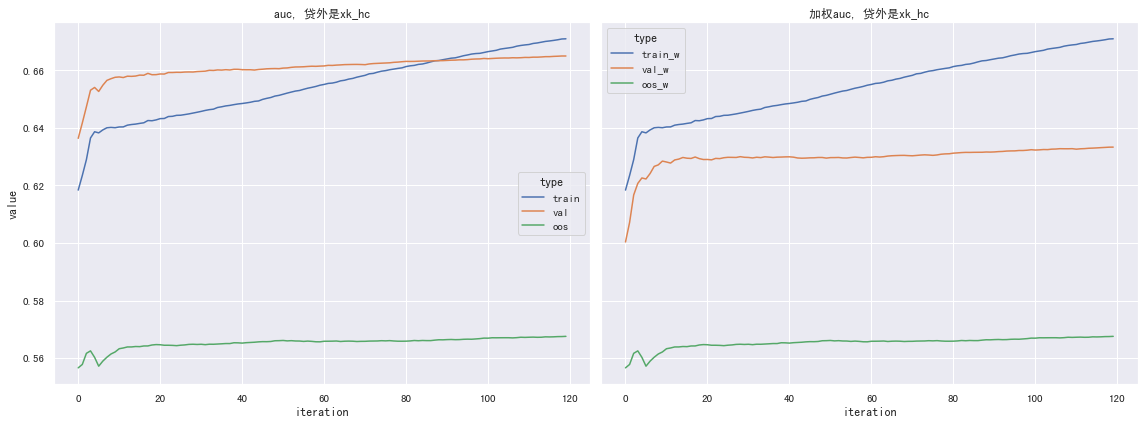

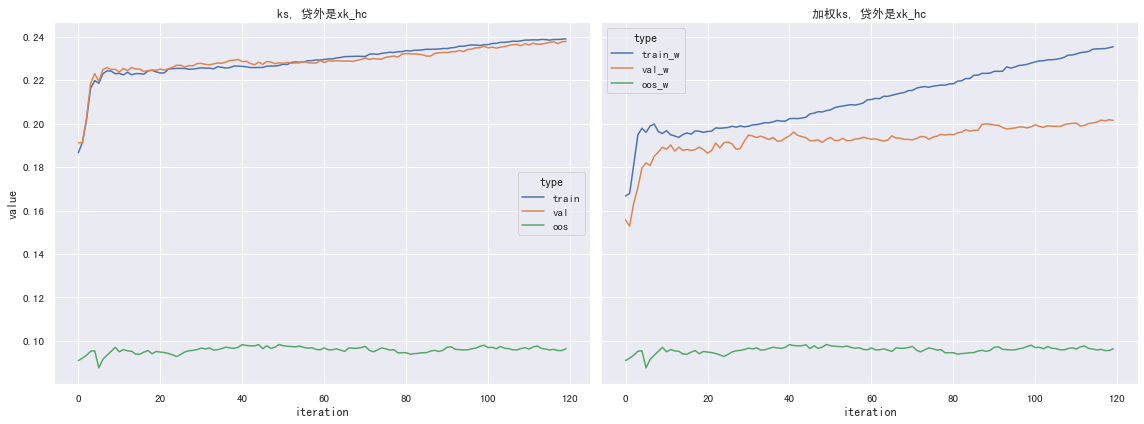

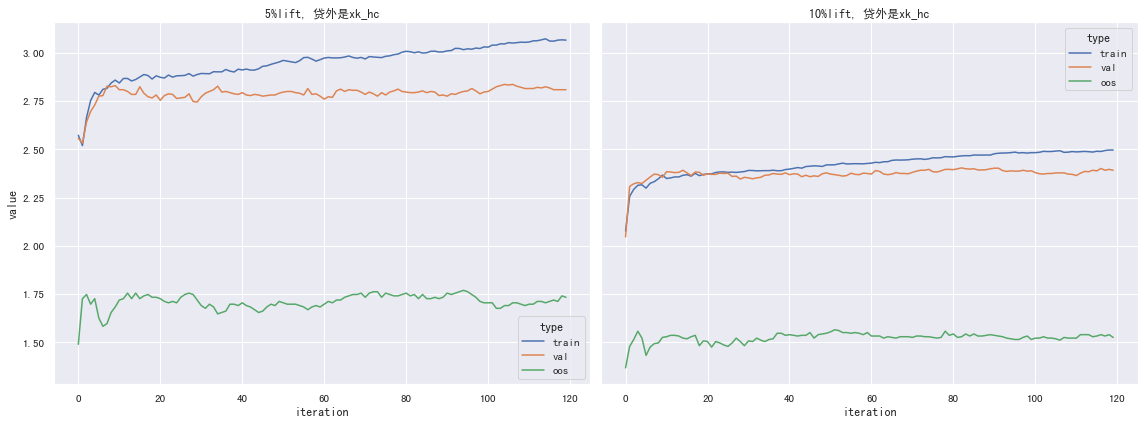

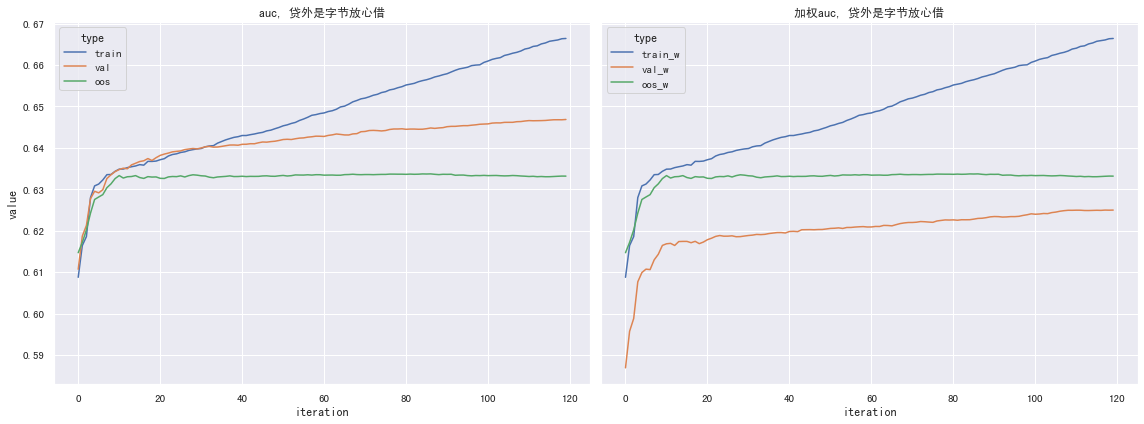

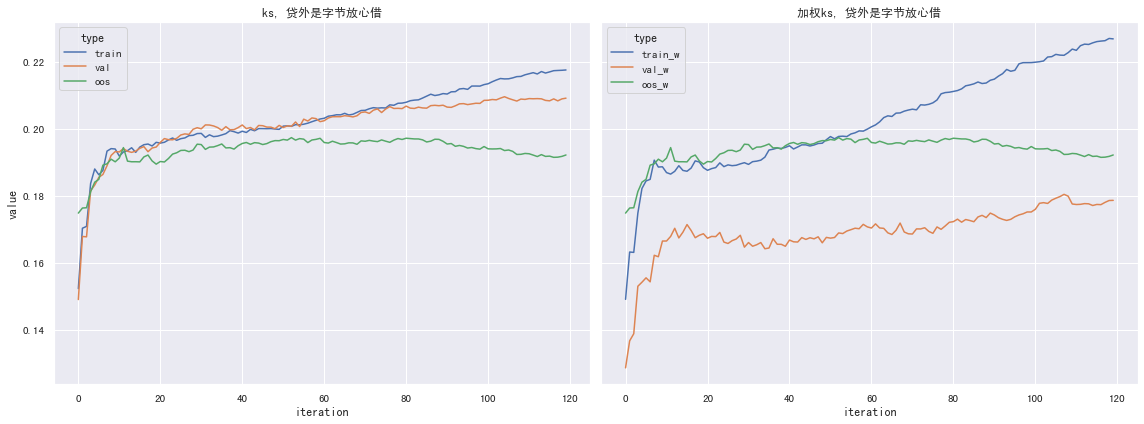

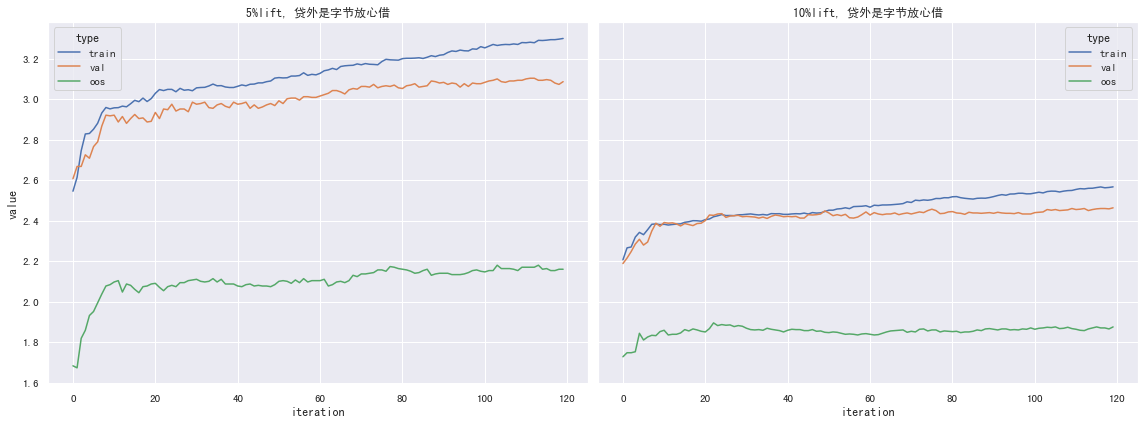

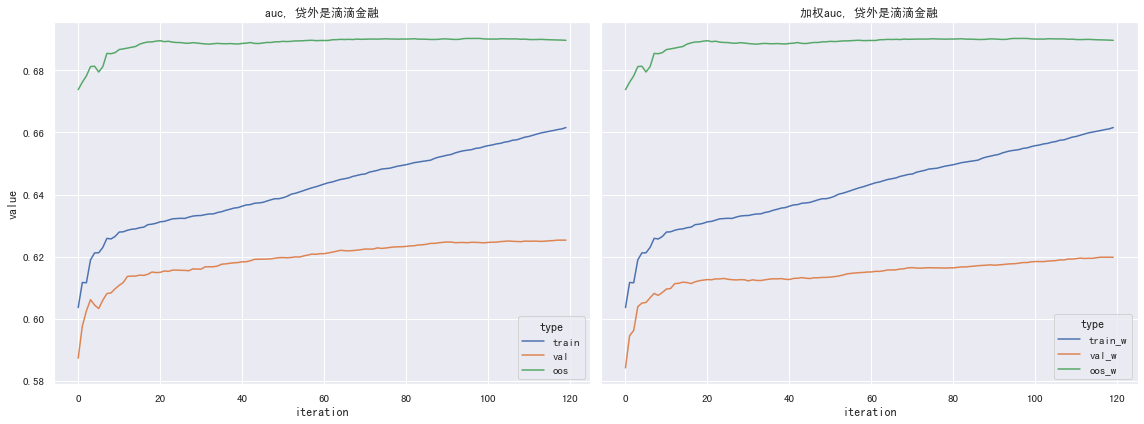

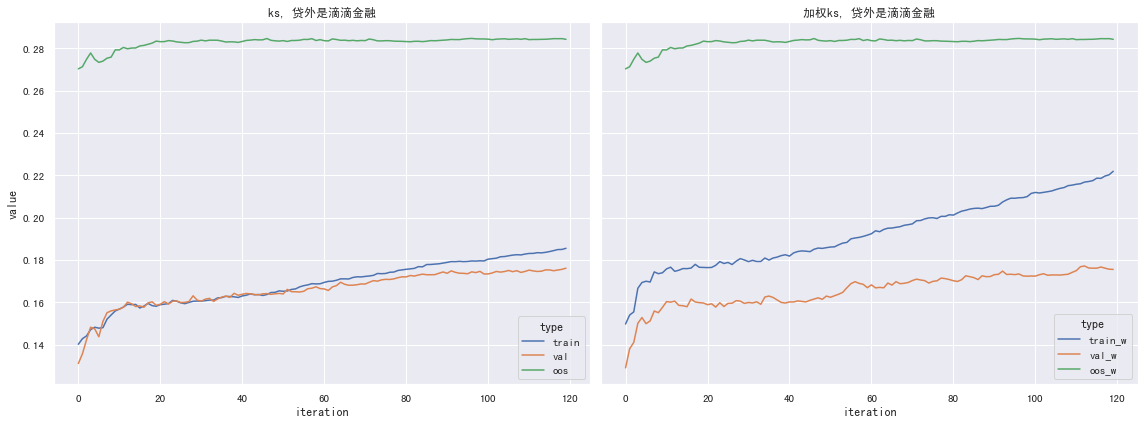

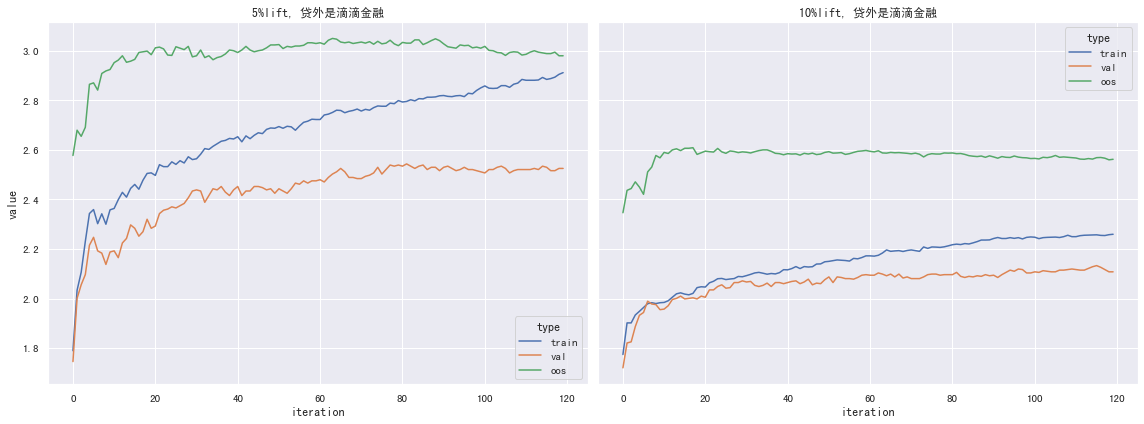

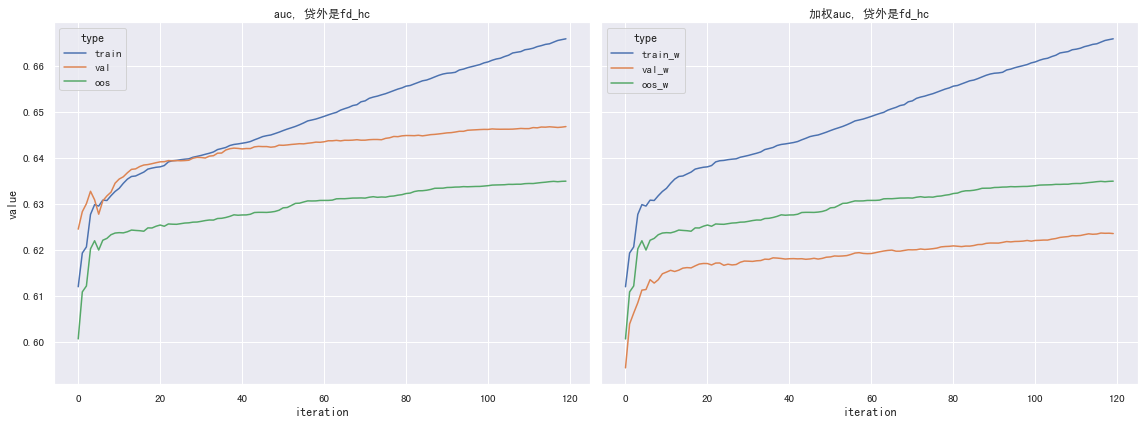

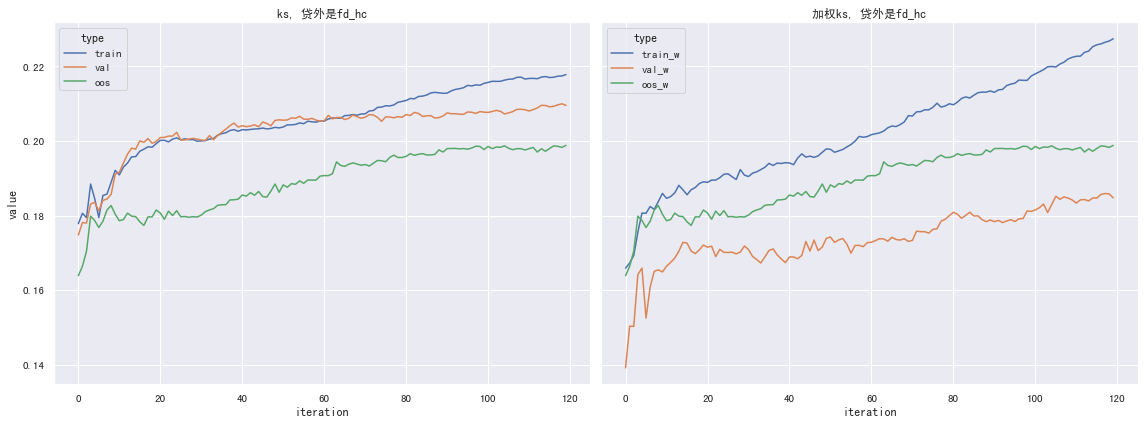

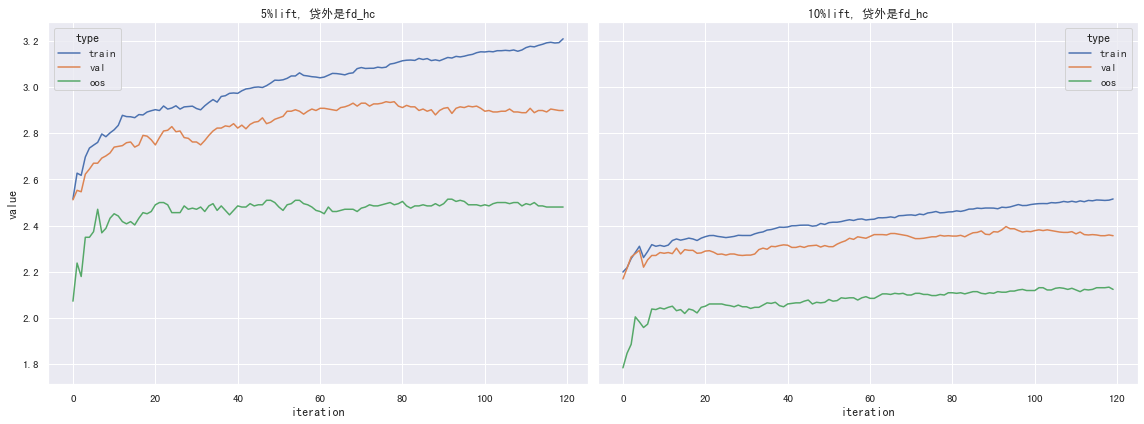

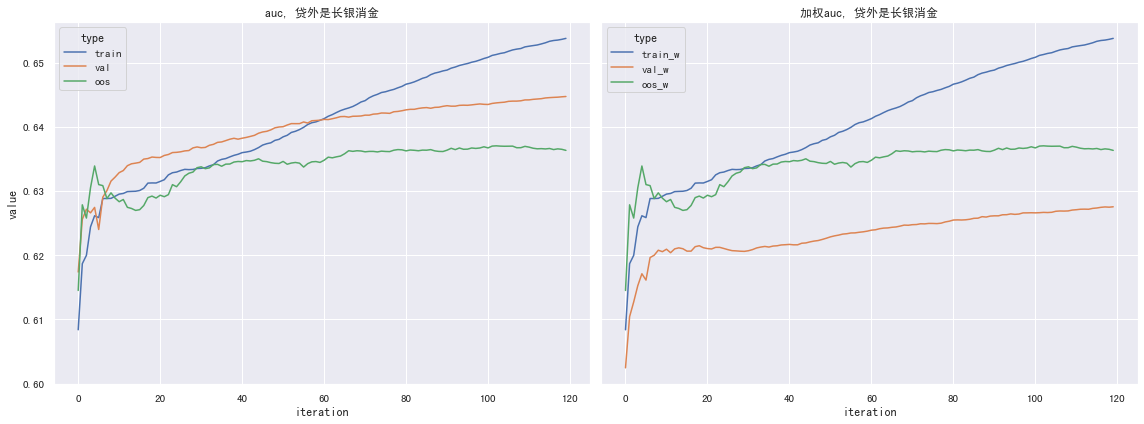

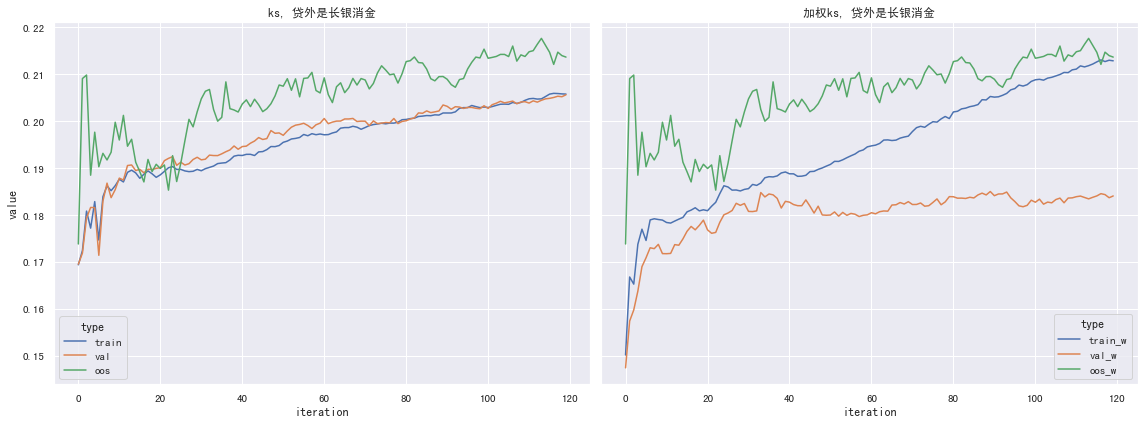

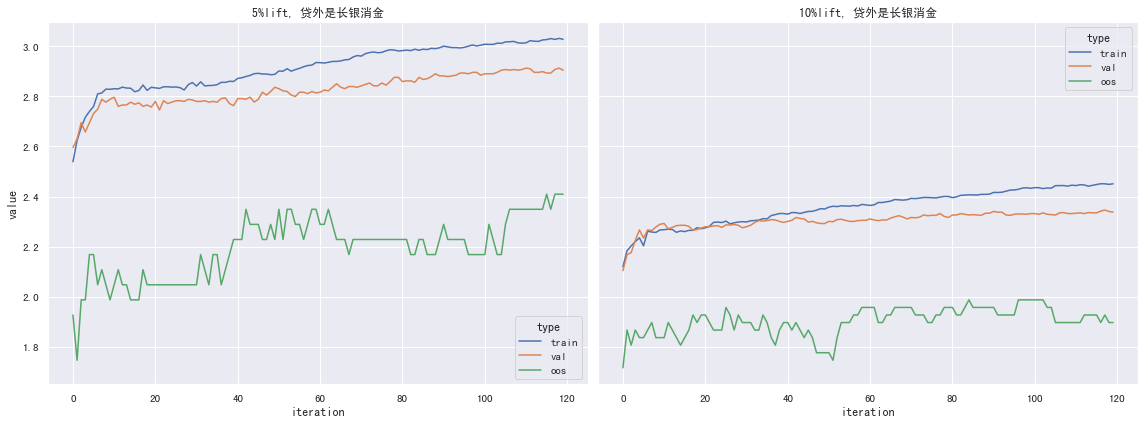

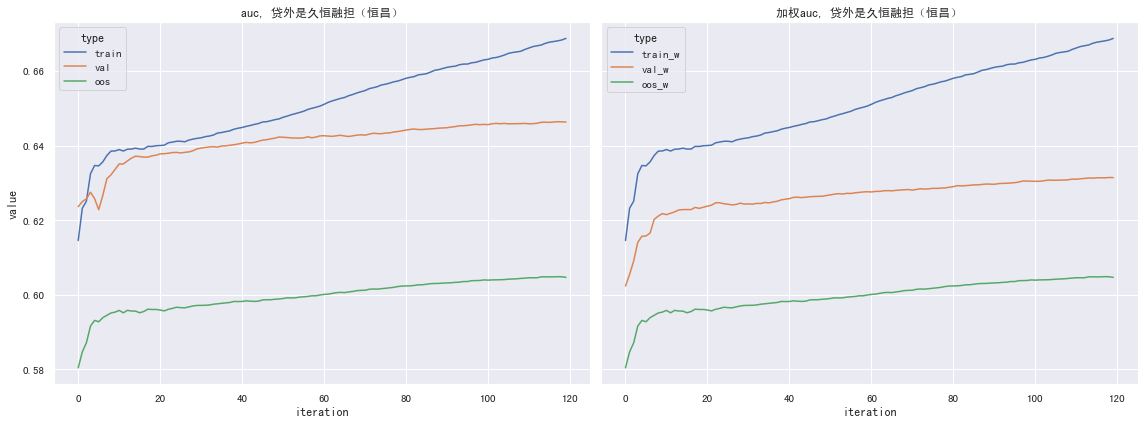

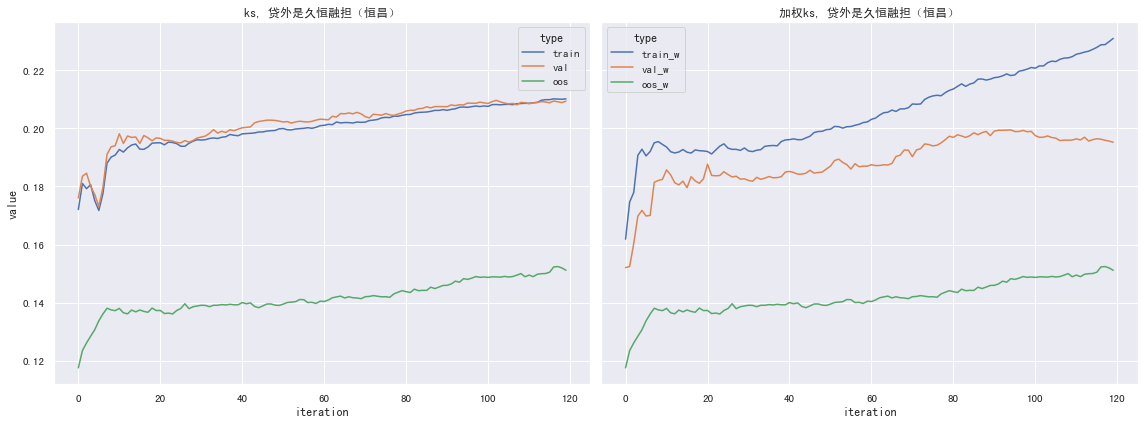

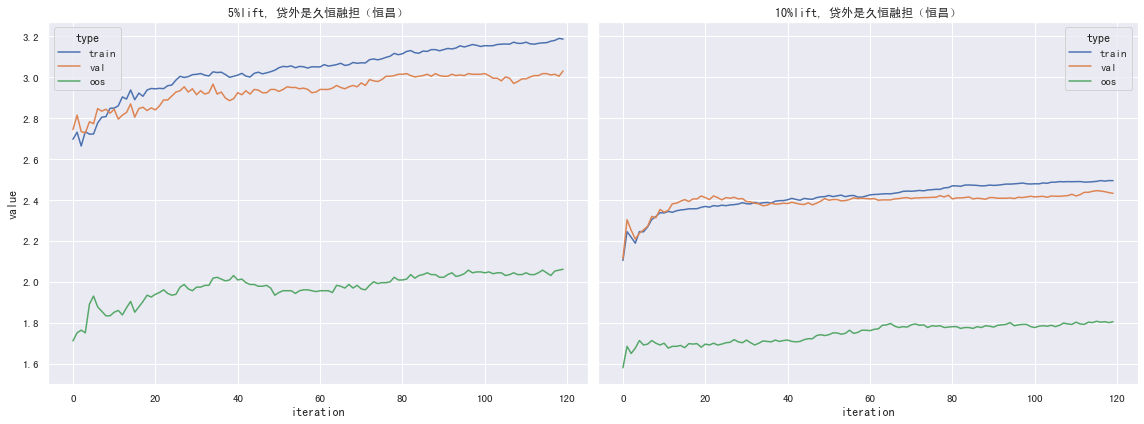

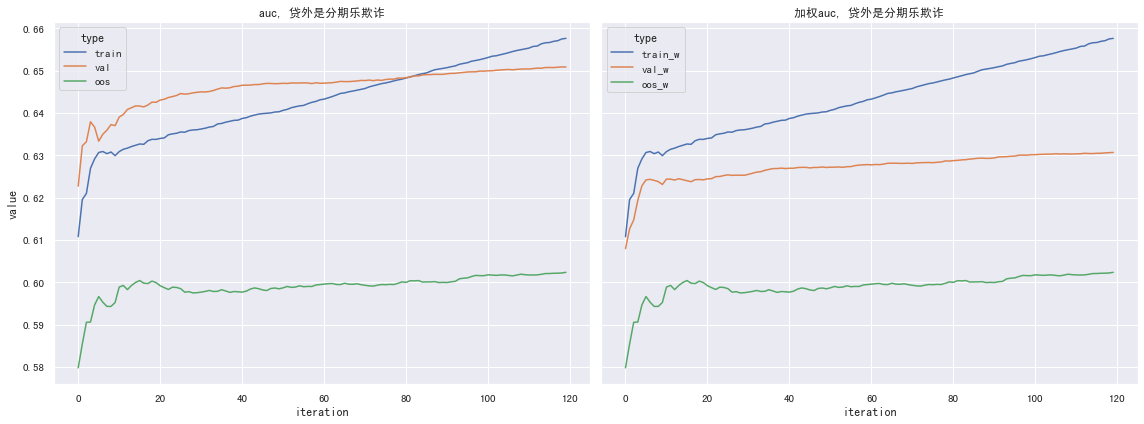

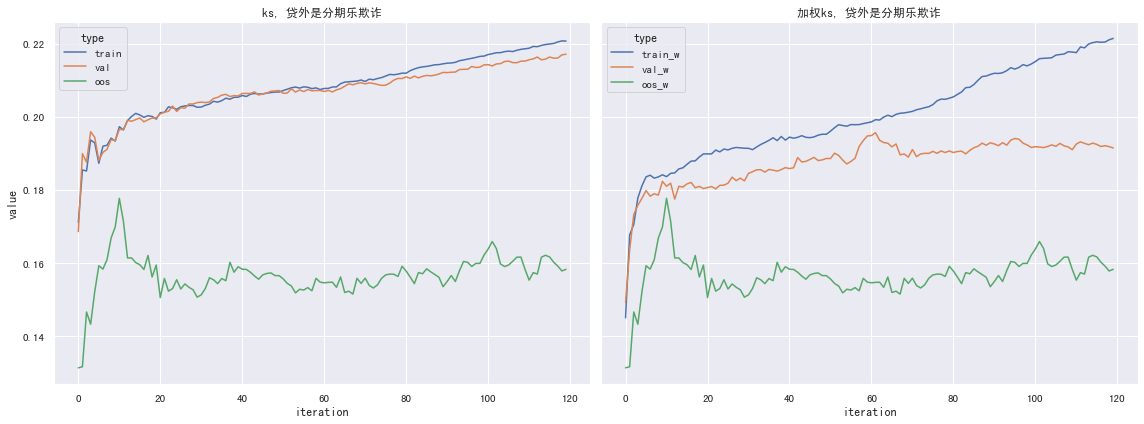

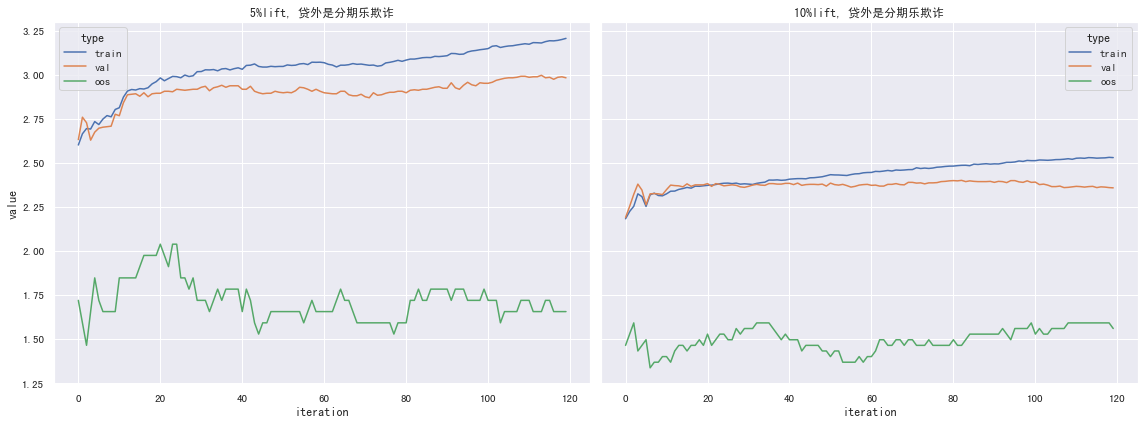

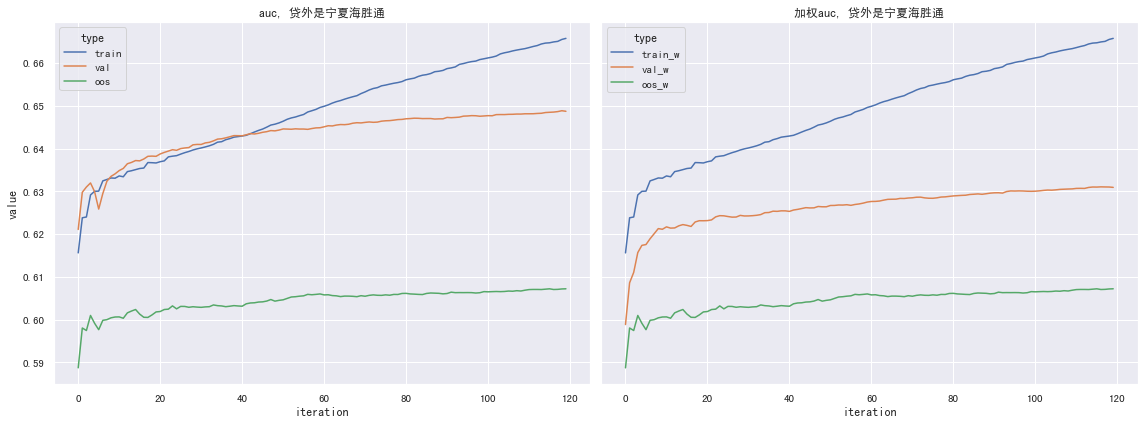

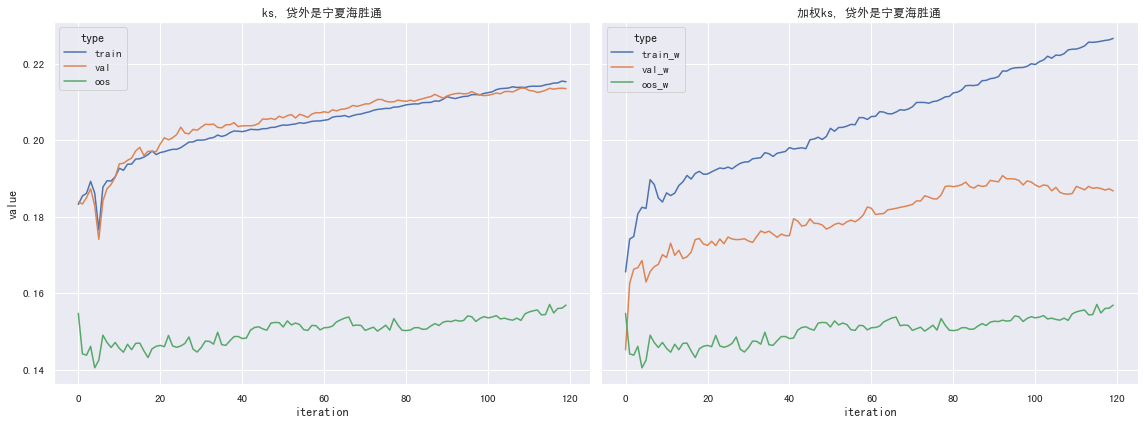

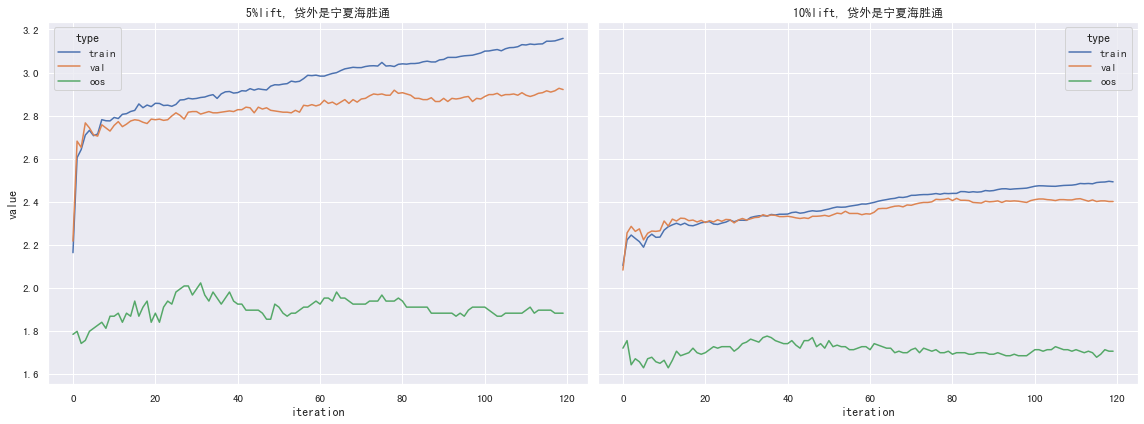

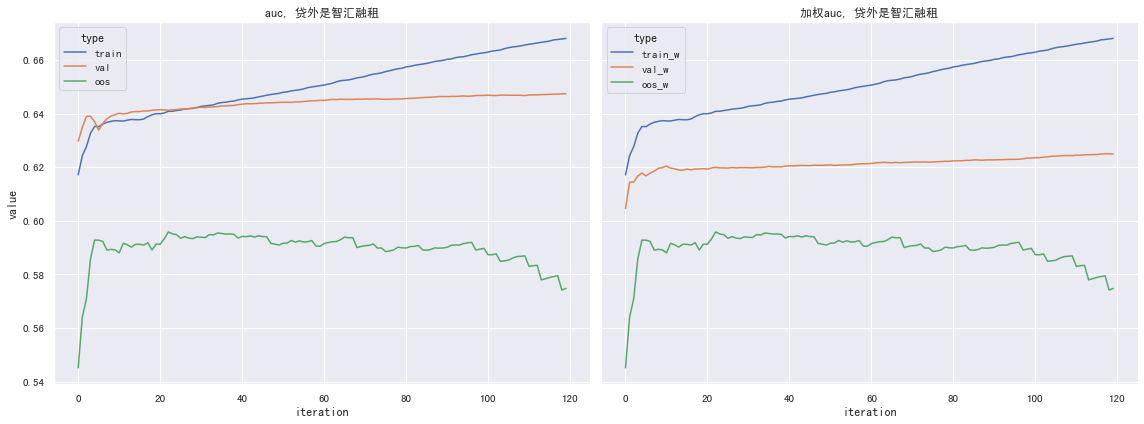

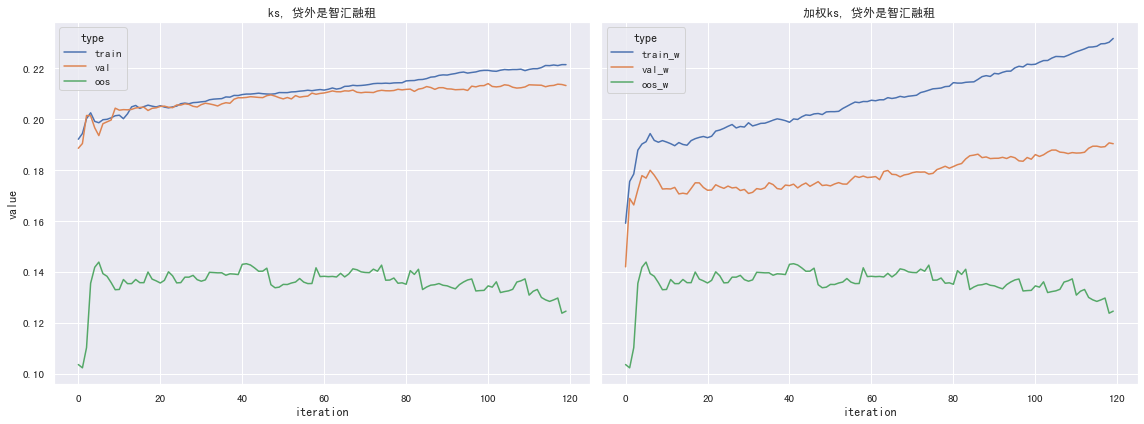

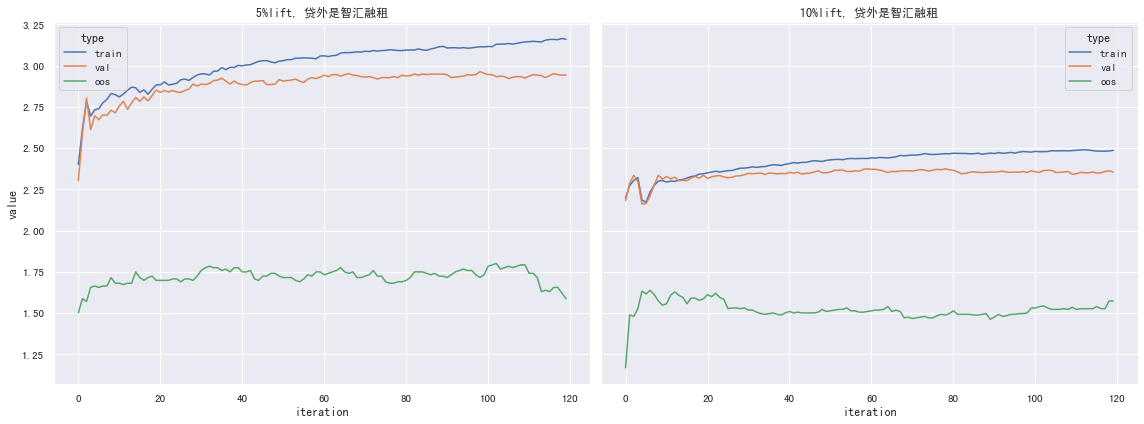

In [6]:
param = {'colsample_bytree': 0.6000000000000001,
         'learning_rate': 0.02,
         'max_bin': 60,
         'max_depth': 4,
         'metric': 'auc',# 请不要去掉此参数，如果有早停将作为依据
         'min_child_weight': 25,
         'num_iterations': 120,
         'num_threads': 3,
         'objective': 'binary',
         'reg_alpha': 2.0,
         'reg_lambda': 2.0,
         'balanced_badrate': 0.1,
         'broadcast_with_tar': False
}

results = pd.read_csv("process results/results.csv")
simpler_results = pd.read_csv("process results/simper_results.csv")
dataset_statis = pd.read_csv("process results/datasetStatis.csv")
randn = 42
store_pth = "process results/"

kwargs = {'data':data, 'oot_data': oot_data, 'oos_data':oos_data, 'param': param, 'randn': randn,
          'results': results, 'simpler_results': simpler_results, 'dataset_statis': dataset_statis,
         'score_name':'score_test', 'store_pth':store_pth ,'score_transform_func':None, "model": None}

inference = Inference(**kwargs)
inference.generate_report()